# Pytroch autodiff example

In [6]:
import torch

x = torch.tensor(5.0, requires_grad=True)
f = 2 * (x ** 2) + 5
f.backward()
print(x.grad)  # This will print the derivative of f with respect to x


tensor(20.)


# Units lookups
kcal/(g * Å) in Å/(ps²) wolfram says: <br>

418.4 Å/ps^2 (ångströms per picosecond squared) <br>

maybe I should have used a unit package but I havent used one before


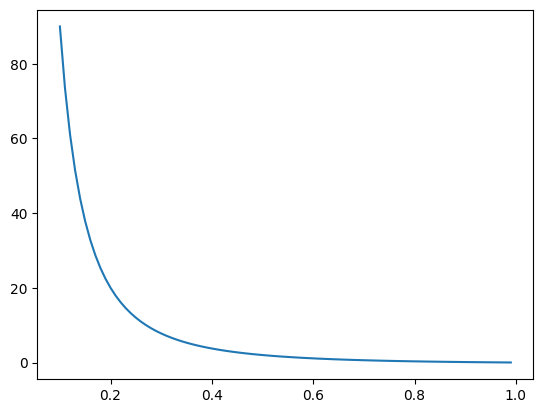

In [158]:
import matplotlib.pyplot as plt
import numpy as np

xx = np.arange(0.1, 1,0.01)  
yy = 1/(xx**2)-1/xx 

plt.plot(xx, yy)
plt.show()


In [272]:
from dataclasses import dataclass
from abc import ABC, abstractmethod
import matplotlib.pyplot as plt
import numpy as np
import torch
from einops import rearrange

@dataclass
class Simulation_constants:
    """Holds simulation constants"""
    m: float = 39.9748 # g/mol , mass
    T: float = 300 # K , T
    sigma: float = 3.4 # A, particle size
    eps: float = 0.24 # kcal/mol interactions_strength
    # A box defined by 2 corners (xi,yi), (xf,yf)
    xi: float = 0 # A
    yi: float = 0 # A
    xf: float = 20 # A
    yf: float = 20 # A


class MD_simulation(ABC):
    def __init__(self,sim_cons,pos_file="intial_pos.csv",vel_file="intial_vel.csv",debug=False):
        self.positions = torch.from_numpy(np.genfromtxt(pos_file)) # A
        self.velocities  = torch.from_numpy(np.genfromtxt(vel_file)) # A/ps
        self.accelerations = torch.zeros_like(self.positions) # A/ps^2 has to be defined
        self.positions.requires_grad = True
        self.constants = sim_cons
        self.total_steps = 0  
        self.debug = debug

        if self.positions.shape != self.velocities.shape:
            raise ValueError("Positions and velocities must have the same shape")
    

    def get_distances_squared(self):   
        # broadcasting points (p) to get z_i - z_j for each coordinate (c), redundant x_j-x_i 
        diff = rearrange(self.positions, 'p c -> p 1 c') - rearrange(self.positions, 'p c -> 1 p c') # A
        return torch.einsum('ijc,ijc->ij', diff, diff) # A^2

    @abstractmethod   
    def get_potential_energy(self):
        pass

    def get_force(self):
        """Calculates the force as the negative gradient of the potential energy."""
        forces, = torch.autograd.grad(self.get_potential_energy(), self.positions, create_graph=True)
        return -forces #kcal/(mol * A)

    @abstractmethod   
    def step(self):
        """Performs a single step of the Velocity Verlet integration algorithm."""
        pass


    def step_reflect(self):
        """Reflects particles that have crossed the boundary."""
        diff_to_axis = rearrange(self.positions, "p c -> 1 p c") - torch.tensor([
            [[self.constants.xi, self.constants.yi]],
            [[self.constants.xf, self.constants.yf]]
        ])

        diff_to_axis[1, :, :] *= -1
        diff_to_axis = torch.min(diff_to_axis, torch.tensor([0]))
        diff_to_axis[0, :, :] *= -1
        pos_adj = 2 * torch.einsum("h p c -> p c", diff_to_axis)
        vel_adj = torch.where(torch.abs(pos_adj) > 0, -1, 1)

        if self.debug:
            print("Debug Information: Reflect Step")
            print("-" * 40)  # Separator for better readability
            print("Current Boundary Corners:")
            print(f"Bottom Left Corner: ({self.constants.xi}, {self.constants.yi})")
            print(f"Top Right Corner: ({self.constants.xf}, {self.constants.yf})")
            print("\nPosition Adjustments (pos_adj):")
            print(pos_adj)
            print("\nVelocity Adjustments (vel_adj):")
            print(vel_adj)
            print("-" * 40)  # Separator for clarity
            self.plt_points()

        # Update positions and velocities
        self.positions = self.positions + pos_adj
        self.velocities = self.velocities * vel_adj

        if self.debug:
            self.plt_points()




    def plt_points(self):
        pos = self.positions.detach().numpy()  # Positions
        vel = self.velocities.detach().numpy()  # Velocities
        acc = self.accelerations.detach().numpy()  # Accelerations

        plt.scatter(pos[:, 0], pos[:, 1], color='blue', label='Particles')  # Scatter plot for the points

        # Annotate each point with an identifier (e.g., index)
        for i, (x, y) in enumerate(pos):
            plt.annotate(f'{i}', (x, y), textcoords="offset points", xytext=(5, 5), ha='center')

            # Add arrows for velocities
            plt.arrow(x, y, vel[i, 0], vel[i, 1],
                    head_width=0.1, head_length=0.2,
                    fc='red', ec='red',
                    length_includes_head=True)  # Draw velocity vectors as arrows

            # Add arrows for accelerations
            plt.arrow(x, y, acc[i, 0], acc[i, 1],
                    head_width=0.1, head_length=0.2,
                    fc='green', ec='green',
                    length_includes_head=True)  # Draw acceleration vectors as arrows

        # Draw the box
        box_x = [self.constants.xi, self.constants.xf, self.constants.xf, self.constants.xi, self.constants.xi]
        box_y = [self.constants.yi, self.constants.yi, self.constants.yf, self.constants.yf, self.constants.yi]
        plt.plot(box_x, box_y, color='black', linestyle='--', label='Boundary Box')  # Draw the box

        # Labels and limits
        plt.xlabel('x-axis')
        plt.ylabel('y-axis')
        plt.xlim(-5, 25)
        plt.ylim(-5, 25)
        plt.grid(True)
        plt.legend()  # Add legend to distinguish the particles and boundary box
        plt.title('Particle Positions with Velocities and Accelerations')
        plt.show()




class MD_simulation_lj_vv(MD_simulation):
    """Implements the Lennard-Jones potential and Velocity Verlet integration step"""

    def __init__(self,sim_cons,pos_file="ipos.csv",vel_file="ivel.csv",debug=False):
        MD_simulation.__init__(self,sim_cons,pos_file,vel_file,debug)
        self.accelerations = self.get_acceleration()


    def get_potential_energy(self):
        """Maybe for calculating the force with autodiff"""
        tmp = self.get_distances_squared() + 1e-9 # added eps, avoid dividing by 0, A^2
        tmp = self.constants.sigma**6/tmp**3 # A^6/A^6 
        tmp = 4*self.constants.eps*tmp*(1-tmp) # kcal/mol
        return torch.einsum("ij->", torch.triu(tmp, diagonal=1)) # kcal/mol
    
    def get_acceleration(self):
        a = self.get_force()/self.constants.m #kcal/(mol * A * (g/mol)) = kcal/(g *A) = 418.4 A/(ps^2)
        a_unit_factor_kcal_per_gA_to_A_per_ps2 = 418.4
        a *= a_unit_factor_kcal_per_gA_to_A_per_ps2
        return a


    def step(self,dt):
        #order matters
        self.positions = self.positions + self.velocities*dt + 0.5*self.accelerations*dt**2
        self.step_reflect()
        new_a = self.get_acceleration() 
        self.velocities = self.velocities + 0.5*(self.accelerations+new_a)*dt
        self.accelerations = new_a
        # print(f"pos= \n{self.positions}, \nvel = \n{self.velocity}, \na = \n{a}")




# testing reflection

Debug Information: Reflect Step
----------------------------------------
Current Boundary Corners:
Bottom Left Corner: (0, 0)
Top Right Corner: (20, 20)

Position Adjustments (pos_adj):
tensor([[-6.4731, -7.6373],
        [ 6.7300,  7.3220],
        [-6.1101,  0.0000],
        [-6.4720,  7.1241],
        [ 6.7300, -7.4380],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  5.1648],
        [ 0.0000, -7.4761]], dtype=torch.float64, grad_fn=<MulBackward0>)

Velocity Adjustments (vel_adj):
tensor([[-1, -1],
        [-1, -1],
        [-1,  1],
        [-1, -1],
        [-1, -1],
        [ 1,  1],
        [ 1,  1],
        [ 1,  1],
        [ 1,  1],
        [ 1, -1],
        [ 1, -1]])
----------------------------------------


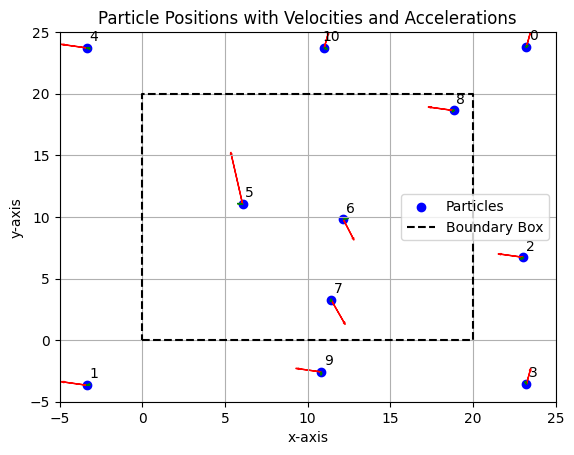

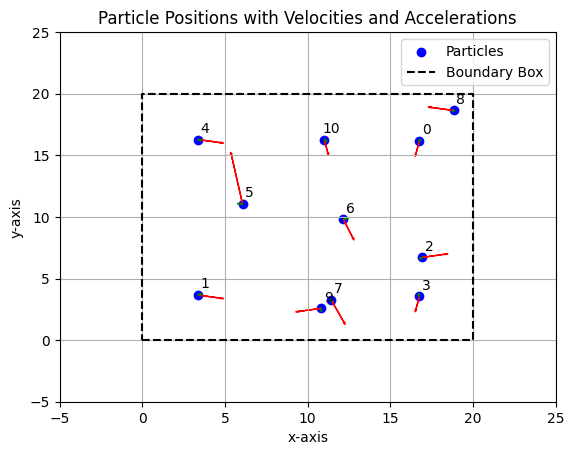

In [273]:
sim_cons = Simulation_constants()
sim = MD_simulation_lj_vv(
    sim_cons=sim_cons,
    pos_file="./test_init/reflect_pos.csv",
    vel_file="./test_init/reflect_vel.csv",
    debug=True
    )
sim.step(dt=0.1)

In [234]:
sim_cons = Simulation_constants()
# sim = MD_simulation_lj_vv(sim_cons)
sim = MD_simulation_lj_vv(sim_cons,pos_file="ipos.csv",vel_file="ivel.csv")

# sim.plt_points()
sim.step(dt=0.1)
# dis= sim.get_distances_squared()
# print(dis.detach().numpy())
# print(sim.get_potential_energy())
# print(sim.get_potential_energy().backward())
# sim.step()
# print(sim.positions)

tensor([[28.2360, 26.8180],
        [28.0550,  6.7190],
        [-8.1840, 26.8180],
        [18.8250, 18.6390]], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([[ 0.2600,  1.2800],
        [-1.5500,  0.2900],
        [ 0.2600,  1.2800],
        [-1.5500,  0.2900]], dtype=torch.float64)
tensor([[-8.2360, -6.8180],
        [-8.0550,  0.0000],
        [ 8.1840, -6.8180],
        [ 0.0000,  0.0000]], dtype=torch.float64, grad_fn=<SumBackward1>)
tensor([[-1, -1],
        [ 1, -1],
        [-1, -1],
        [ 1,  1]])
tensor([[20.0000, 20.0000],
        [20.0000,  6.7190],
        [ 0.0000, 20.0000],
        [18.8250, 18.6390]], dtype=torch.float64, grad_fn=<AddBackward0>)
tensor([[-0.2600, -1.2800],
        [-1.5500, -0.2900],
        [-0.2600, -1.2800],
        [-1.5500,  0.2900]], dtype=torch.float64)
